<div id="img1-container">
    <!-- <img id="img1" src="images/apartment-building.jpg" alt="Description of the image" /> -->
    <!-- <img id="img1" src="images/blue-bg.jpg" alt="Description of the image" /> -->
</div>


In [13]:
from IPython.display import HTML, Image, display

html = """

<div id="cover-page-container">
    <img id="cover-page-image" src="images/blue-bg.jpg" alt="Description of the image" />
    <div id="title-container">
        <h1>Ancient Heights Apartments</h1>
        <div id="meta-data-container">
            <div>February 5, 2026</div>
            <div>by Aaron Hardy</div>
        </div>
    </div>
    <div id="title-bar"></div>
</div>
"""

display(HTML(html))

## Summary

Ancient heights is a hypothetical existing apartment property located in the city of Knoxville, Tennesee. This analysis will demonstrate one way to analyze an apartment commerial real estate investment. The analysis covers cash flows, financing, valuation, and risk. The economic outlook of Knoxville, Tennesee plays a large role in determining the risk and future cash flows of the property.


In [14]:
from IPython.display import display, HTML

html = """
<img id="img-apartment-building" src="images/apartment-building.jpg" />
"""

display(HTML(html))

Going into Q1 2026, the Knoxville area economic and housing market trends indicated moderate tailwinds making apartment properties relatively attractive for sellers.


In [15]:
# from IPython.display import HTML, display

html = """

<div class="note"> 
    <div class="note-title">NOTE:</div>
    <div class="note-body">
    Knox County, TN is a county that includes the city of Knoxville as the main city and various surrounding cities and areas.
    </div>
</div>
"""

display(HTML(html))

In [16]:
from IPython.display import HTML

HTML(
    """
    <link href="https://fonts.googleapis.com/css2?family=Roboto:wght@400;700&display=swap" rel="stylesheet">

    <link rel="stylesheet" href="custom.css">
    <script src="custom.js" defer></script>
    <style>
        div.jp-OutputPrompt.jp-OutputArea-prompt {
            display: none !important;
        }
    
        .jp-OutputPrompt {
            display: none !important;
        }

        .jp-Notebook-cell.celltag_remove_cell {
            display: none !important;
        }
    </style>

    """
)

In [17]:
# %load_ext autoreload
# %autoreload 2

# import importlib
import import_ipynb
from dotenv import load_dotenv
import os
from fredapi import Fred
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import dataframe_image as dfi
import sys

# plt.rcParams["font.family"] = "Arial"  # Or choose any other font that you prefer
# import warnings

# Suppress specific warnings
# warnings.filterwarnings("ignore", message="Glyph 13")


if ".." not in sys.path:
    sys.path.append("..")  # Add parent directory to path

import utils.logs as logs  # log_change
import utils.tables as tables  # export_table
import utils.line_plots as line_plots  # plot_line
import utils.bar_plots as bar_plots  # plot_bars
import utils.fred as fred  # get_metadata_table
import utils.case as case  # snake_to_title_case


sns.set_theme(style="ticks")

In [18]:
# "knox_county_pop": "TNKNOX5POP",
# "us_pop": "POPTHM",

series_ids = [
    "POPTHM",
    "TNKNOX5POP",
    # "ATNHPIUS47093A",
    # "USSTHPI",
    "REALGDPALL47093",
    "GDPC1",
    "MEDLISPRI47093",
    "MEDLISPRIUS",
]


df_metadata = pd.read_excel("../data/fred_series_metadata.xlsx")
# print(df_metadata)

# df_metadata = df_metadata.loc[:, ~df_metadata.columns.str.startswith("Unnamed")]

try:
    df_metadata
except NameError:
    df_metadata = fred.get_metadata_table(series_ids)

df_metadata = case.snake_to_title_case(df_metadata)


url_prefix = "https://fred.stlouisfed.org/series/"
df_metadata["Notes"] = df_metadata.apply(
    lambda row: (
        row["Notes"][:200]
        + "..."
        + f' <a href="{url_prefix + row["Series Id"]}">More</a>'
        if len(row["Notes"]) > 200
        else row["Notes"]
    ),
    axis=1,
)

# df_metadata = df_metadata.replace(r"\r", " ", regex=True)

# print(df_metadata)
min_widths = {
    "Title": "50px",
    "Notes": "400px",
}


tables.pretty_table(
    df_metadata,
    min_widths=min_widths,
    max_width="200px",
    font_size="12px",
    show_index=False,
)

# df_metadata.to_excel("../data/fred_series_metadata.xlsx", index=False)

Series Id,Title,Units,Frequency,Seasonal Adjustment,Last Updated,Start Date,End Date,Notes
POPTHM,Population,Thousands,Monthly,Not Seasonally Adjusted,2026-01-22 10:29:41-06,1959-01-01,2025-11-01,Population includes resident population plus armed forces overseas. The monthly estimate is the average of estimates for the first of the month and the first of the following month. BEA Account Code:... More
TNKNOX5POP,"Resident Population in Knox County, TN",Thousands of Persons,Annual,Not Seasonally Adjusted,2025-03-14 11:43:58-05,1970-01-01,2024-01-01,"Data for ""Resident Population"" are estimates as of July 1. Data for 1970, 1980, 1990, and 2000 are annual census. Population estimates are updated annually using current data on births, deaths, and m... More"
ATNHPIUS47093A,"All-Transactions House Price Index for Knox County, TN",Index 2000=100,Annual,Not Seasonally Adjusted,2025-03-25 09:28:53-05,1975-01-01,2024-01-01,"As stated by the source, these annual county indexes should be considered developmental. As with the standard FHFA HPIs, revisions to these indexes may reflect the impact of new data or technical adju... More"
USSTHPI,All-Transactions House Price Index for the United States,Index 1980:Q1=100,Quarterly,Not Seasonally Adjusted,2025-11-25 09:05:09-06,1975-01-01,2025-07-01,Estimated using sales prices and appraisal data.
REALGDPALL47093,"Real Gross Domestic Product: All Industries in Knox County, TN",Thousands of Chained 2017 U.S. Dollars,Annual,Not Seasonally Adjusted,2026-02-05 08:59:59-06,2001-01-01,2024-01-01,GDP by county is a measure of the market value of final goods and services produced within a county area in a particular period. While other measures of county economies rely mainly on labor market da... More
GDPC1,Real Gross Domestic Product,Billions of Chained 2017 Dollars,Quarterly,Seasonally Adjusted Annual Rate,2026-01-22 07:46:36-06,1947-01-01,2025-07-01,BEA Account Code: A191RX Real gross domestic product is the inflation adjusted value of the goods and services produced by labor and property located in the United States.For more information see the... More
MEDLISPRI47093,"Housing Inventory: Median Listing Price in Knox County, TN",U.S. Dollars,Monthly,Not Seasonally Adjusted,2026-02-06 17:24:43-06,2016-07-01,2026-01-01,"The median listing price in a given market during the specified month. With the release of its September 2022 housing trends report, Realtor.com® incorporated a new and improved methodology for captu... More"
MEDLISPRIUS,Housing Inventory: Median Listing Price in the United States,U.S. Dollars,Monthly,Not Seasonally Adjusted,2026-02-06 17:11:49-06,2016-07-01,2026-01-01,"The median listing price in a given market during the specified month. With the release of its September 2022 housing trends report, Realtor.com® incorporated a new and improved methodology for captu... More"


In [19]:
# df.reset_index(names="Date", inplace=True)
# df.to_csv("data/fred-data.csv", index=False)

# series_list = []
# series_list.append(s)
# df = pd.concat(series_list, axis=1)

fred = Fred(api_key=os.getenv("FRED_API_KEY"))

series_ids = {
    "Population": {
        "Population Knox County": "TNKNOX5POP",
        "Population U.S.": "POPTHM",
    },
    # "Home Price Transaction Index": {
    #     "Transaction Index Knox County": "ATNHPIUS47093A",
    #     "Transaction Index U.S.": "USSTHPI",
    # },
    "GDP": {
        "GDP Knox County": "REALGDPALL47093",
        "GDP U.S.": "GDPC1",
    },
    "Median List Price": {
        "Median List Price Knox County": "MEDLISPRI47093",
        "Median List Price U.S.": "MEDLISPRIUS",
    },
    "Mortage Rate": {"30-Year Mortgage Rate U.S.": "MORTGAGE30US"},
}


def fetch_data(series_ids):
    for group, ids in series_ids.items():
        for series in ids.values():
            df = fred.get_series(series).to_frame(name=series)
            df.to_csv(f"data/raw/{series}.csv", index_label="Date")


# fetch_data(series_ids=series_ids)

In [20]:
"""Data Cleaning"""

""" 
GDP 
"""

# Real Gross Domestic Product: All Industries in Knox County, TN
# not seasonally adjusted, annual
id = "REALGDPALL47093"
gdp_knox = pd.read_csv(f"data/raw/{id}.csv", index_col="Date", parse_dates=["Date"])

# Change from January 1st (BOY) to December 31st (EOY)
gdp_knox.index = gdp_knox.index + pd.offsets.YearEnd()
gdp_knox["GDP Knox County TTM"] = gdp_knox["REALGDPALL47093"]
gdp_knox.to_csv(f"data/cleaned/{id}.csv", index_label="Date")

logs.log_change("Dates changed to end-of-year.", f"data/cleaned/{id}.txt")

# Real Gross Domestic Product
# seasonally adjusted, quarterly
id = "GDPC1"
gdp_us = pd.read_csv(f"data/raw/{id}.csv", index_col="Date", parse_dates=["Date"])
# Adjust each date to the end of its quarter
gdp_us.index = gdp_us.index + pd.offsets.QuarterEnd()
# us_gdp (GDPC1): seasonally adjusted annual (quarterly x 4), quarterly
gdp_us["GDP U.S. Quarterly"] = gdp_us["GDPC1"].div(4)
gdp_us["GDP U.S. TTM"] = gdp_us["GDP U.S. Quarterly"].rolling(4).sum()

gdp_us.to_csv(f"data/cleaned/{id}.csv", index_label="Date")
logs.log_change(
    "Dates changed to end-of-quarter. Computed quarterly figures and trailing twelve month figures.",
    f"data/cleaned/{id}.txt",
)

"""
Population
"""

# Resident Population in Knox County, TN
id = "TNKNOX5POP"
pop_knox = pd.read_csv(f"data/raw/{id}.csv", index_col="Date", parse_dates=["Date"])
# Change from January 1st (BOY) to December 31st (EOY)
pop_knox.index = pop_knox.index + pd.offsets.YearEnd()
pop_knox.to_csv(f"data/cleaned/{id}.csv", index_label="Date")
logs.log_change("Dates changed to end-of-year.", f"data/cleaned/{id}.txt")


# Population in the United States
id = "POPTHM"
pop_us = pd.read_csv(f"data/raw/{id}.csv", index_col="Date", parse_dates=["Date"])
# Adjust each date to the end of month
pop_us.index = pop_us.index + pd.offsets.MonthEnd()
pop_us.to_csv(f"data/cleaned/{id}.csv", index_label="Date")
logs.log_change(
    "Dates changed to end-of-month.",
    f"data/cleaned/{id}.txt",
)

"""
Median List Price
"""

# "Housing Inventory: Median Listing Price in Knox County, TN"
# Monthly, not seasonally adjusted
id = "MEDLISPRI47093"
med_price_knox = pd.read_csv(
    f"data/raw/{id}.csv", index_col="Date", parse_dates=["Date"]
)

# Adjust each date to the end of month
med_price_knox.index = med_price_knox.index + pd.offsets.MonthEnd()
med_price_knox.to_csv(f"data/cleaned/{id}.csv", index_label="Date")
logs.log_change(
    "Dates changed to end-of-month.",
    f"data/cleaned/{id}.txt",
)


# "Housing Inventory: Median Listing Price in the United States"
# Monthly, not seasonally adjusted
id = "MEDLISPRIUS"
med_price_us = pd.read_csv(f"data/raw/{id}.csv", index_col="Date", parse_dates=["Date"])

# Adjust each date to the end of month
med_price_us.index = med_price_us.index + pd.offsets.MonthEnd()
med_price_us.to_csv(f"data/cleaned/{id}.csv", index_label="Date")
logs.log_change(
    "Dates changed to end-of-month.",
    f"data/cleaned/{id}.txt",
)


# long = df.melt(ignore_index=False)

# long["pct_chg"] = long.groupby("variable")["value"].pct_change(
#     periods=1, fill_method=None
# )

# data = df.melt(id_vars="Date")
#     long = long.sort_values(["variable", long.index.name])

#     # Convert to wide format for plotting
#     wide = long.pivot_table(
#         index=long.index, columns="variable", values="pct_chg"
#     ).dropna(how="all")

## Property Overview

- Location: 123 Elm Street, Knoxville, Tennessee, USA
- Type: Multi-family Apartment Complex
- Rental Units: 90
- Average rent per unit: $1,900/month (a/o December 2025)
- Occupancy rate: 95%


## Property Location

Ancient Heights Apartments is located in Knoxville, a city in eastern Tennessee known for its growing population, property values, and employment. The city has a diverse economy, with major contributions from education, healthcare, manufacturing, energy research, and tourism supporting steady growth and regional stability.


In [21]:
# Rental Vacancy Rates
ht = pd.read_html(
    "https://www.doorloop.com/blog/rental-vacancy-statistics#rental-vacancy-rates-by-state"
)

state = ht[1]
tn = state[state["State"] == "Tennessee"].copy()

city = ht[3]
knox = city[city["Metropolitan Area"] == "Knoxville, TN"].copy()

tn.rename(columns={"State": "Location"}, inplace=True)
knox.rename(columns={"Metropolitan Area": "Location"}, inplace=True)

state_tn = ht[4]
# us= city[]

vacancy = pd.concat([tn, knox], axis=0)
vacancy = vacancy.loc[:, ~vacancy.columns.str.startswith("Change")]
long = vacancy.melt(id_vars="Location")
long.loc[len(long)] = ["Tennessee", "2022", "7.3%"]
long.loc[len(long)] = ["Tennessee", "2021", "7.4%"]
long.loc[len(long)] = ["Tennessee", "2020", "8.3%"]
long.sort_values(["Location", "variable"], ascending=[False, True], inplace=True)


tn = long.loc[long["Location"] == "Tennessee", :].copy()
kx = long.loc[long["Location"] == "Knoxville, TN", :].copy()

tn.rename(columns={"Location": "", "variable": "Year", "value": "Growth"}, inplace=True)
kx.rename(columns={"Location": "", "variable": "Year", "value": "Growth"}, inplace=True)

tables.pretty_table(
    tn,
    # min_widths=min_widths,
    font_size="12px",
    show_index=False,
)

,Year,Growth
Tennessee,2020,8.3%
Tennessee,2021,7.4%
Tennessee,2022,7.3%
Tennessee,2023,7.8%
Tennessee,2024,8.2%


In [22]:
tables.pretty_table(
    kx,
    # min_widths=min_widths,
    font_size="12px",
    show_index=False,
)

,Year,Growth
"Knoxville, TN",2023,4.2%
"Knoxville, TN",2024,4.0%


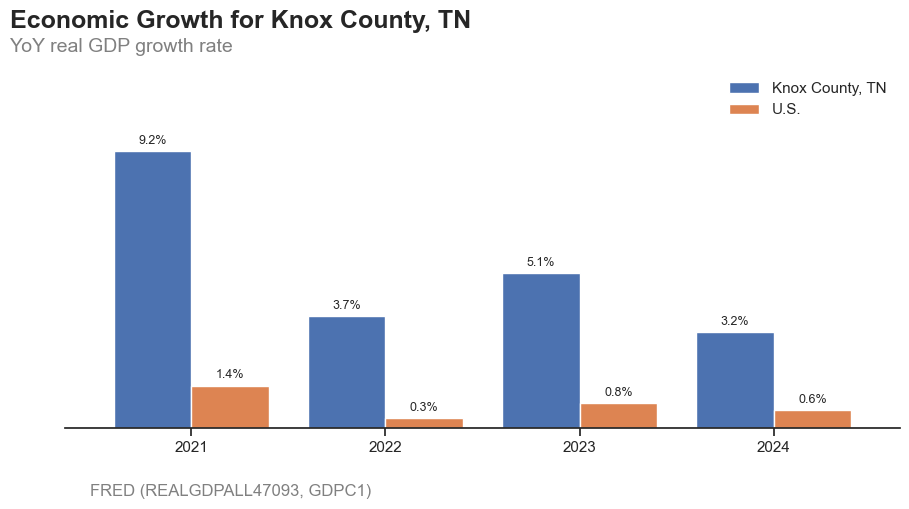

In [ ]:
# GDP Plot

gdp_us = pd.read_csv(
    "data/cleaned/GDPC1.csv", index_col="Date"
)  # , parse_dates=["Date"])
gdp_knox_co = pd.read_csv(
    "data/cleaned/REALGDPALL47093.csv", index_col="Date"
)  # , parse_dates=["Date"]

gdp = gdp_us.join(gdp_knox_co)
gdp = gdp.loc["2020-12-31":, ["GDP U.S. TTM", "GDP Knox County TTM"]]

long = gdp.melt(ignore_index=False)
long.dropna(inplace=True)

long["pct_chg"] = long.groupby("variable")["value"].pct_change()
# print(long)
# long.dropna(inplace=True)
wide = long.pivot_table(index=long.index, columns="variable", values="pct_chg")

wide.dropna(inplace=True)

bar_plots.plot_bars(
    df=wide,
    y=["GDP Knox County TTM", "GDP U.S. TTM"],
    footnote="FRED (REALGDPALL47093, GDPC1)",
    title="Economic Growth for Knox County, TN",
    subtitle="Yearly real GDP growth rate",
    date_format="%Y",
    hide_yaxis=True,
    bar_width=0.8,
    legend_labels=["Knox County, TN", "U.S."],
    file_name="gdp",
    show=True,
)

                  variable     value
Date                                
2016-09-30     MEDLISPRIUS  255000.0
2016-12-31     MEDLISPRIUS  249900.0
2017-03-31     MEDLISPRIUS  264450.0
2017-06-30     MEDLISPRIUS  279000.0
2017-09-30     MEDLISPRIUS  275000.0
...                    ...       ...
2024-12-31  MEDLISPRI47093  428000.0
2025-03-31  MEDLISPRI47093  429900.0
2025-06-30  MEDLISPRI47093  434925.0
2025-09-30  MEDLISPRI47093  425000.0
2025-12-31  MEDLISPRI47093  425000.0

[76 rows x 2 columns]


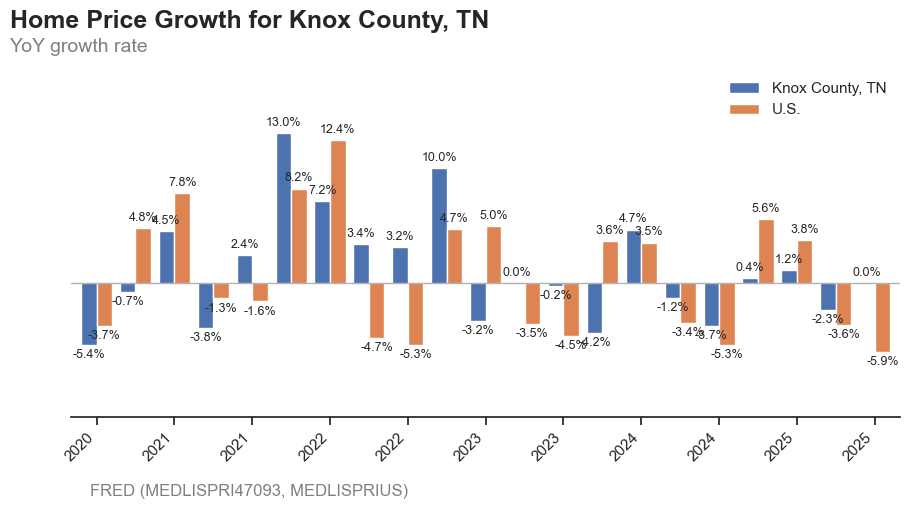

## Demographics

Knox county has experienced steady population growth over the past five years. Population growth ranged between 0.7 and 2.2% per year compared to U.S. growth between 0.1 and 0.9% per year. Economic growth in Knox county and relatively low taxes and affordable living has attracted a steady flow of new residents. The population of Knoxville, Tennessee grew at a higher rate than the national growth rate over each of the four years ending January 1, 2024.


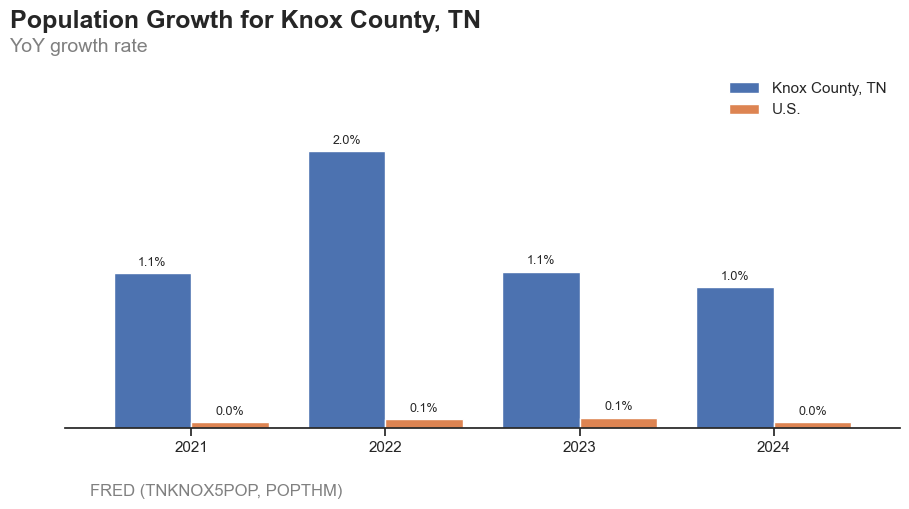

In [ ]:
# Population Plot

pop_us = pd.read_csv(
    "data/cleaned/POPTHM.csv", index_col="Date"
)  # , parse_dates=["Date"])
pop_knox = pd.read_csv(
    "data/cleaned/TNKNOX5POP.csv", index_col="Date"
)  # , parse_dates=["Date"]

pop = pop_us.join(pop_knox)
pop = pop.loc["2020-12-31":, ["POPTHM", "TNKNOX5POP"]]

long = pop.melt(ignore_index=False)
long.dropna(inplace=True)

long["pct_chg"] = long.groupby("variable")["value"].pct_change()
long.dropna(inplace=True)
wide = long.pivot_table(index=long.index, columns="variable", values="pct_chg")

wide.dropna(inplace=True)

bar_plots.plot_bars(
    df=wide,
    y=["TNKNOX5POP", "POPTHM"],
    footnote="FRED (TNKNOX5POP, POPTHM)",
    title="Population Growth for Knox County, TN",
    subtitle="Yearly growth rate",
    date_format="%Y",
    hide_yaxis=True,
    bar_width=0.8,
    legend_labels=["Knox County, TN", "U.S."],
    file_name="population",
    show=True,
)

# pop_growth = pop_growth.pivot(columns="variable", values="pct_chg")
# pop_growth.index.name = None
# pop_growth.columns.name = "Date"

In [ ]:
# from IPython.display import Image, display

# display(Image(filename="plots/pop_growth.png"))

## State of the Economy

### GDP


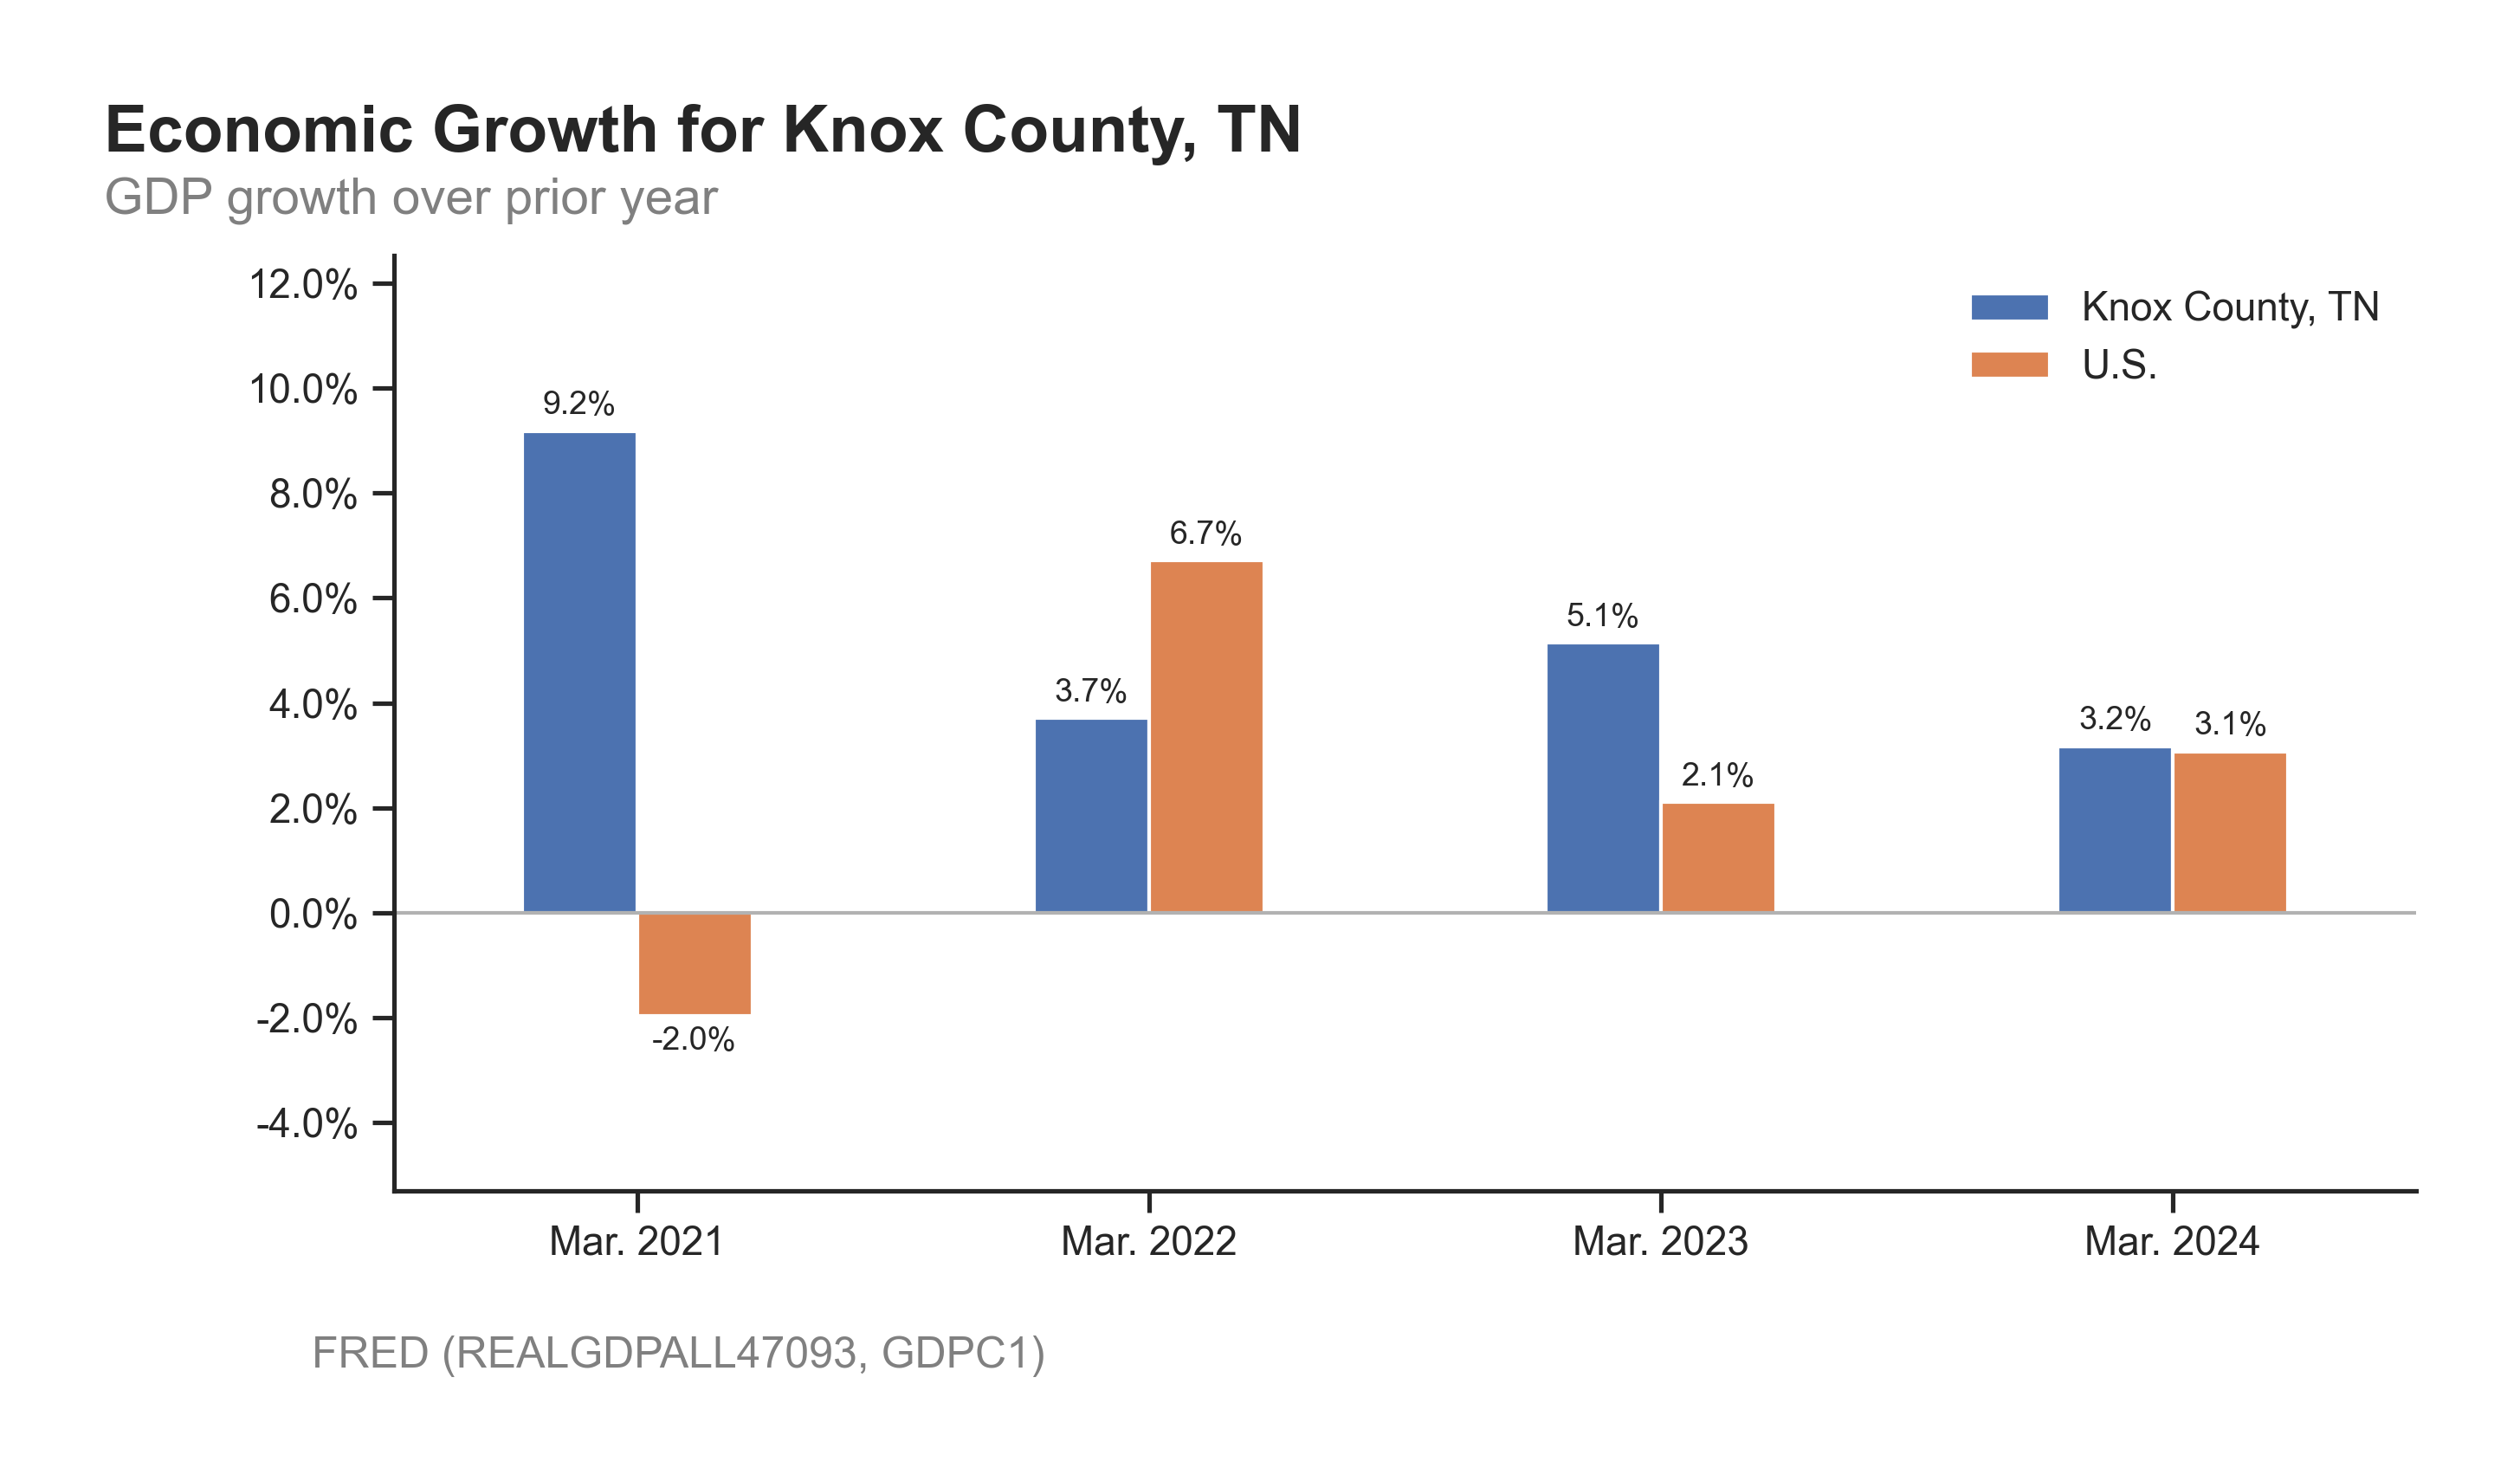

In [ ]:
from IPython.display import Image, display

display(Image(filename="plots/gdp.png"))

### Employment

Growth in employment is another factor that can drive demand for apartment housing. As employment grows new residents often choose apartments over single-family homes.


In [ ]:
from IPython.display import HTML, display

html = """
<div class="panel-container">
    <div class="panel">
        <div class="panel-title">Total Employment<sup>2</sup></div>
        <div class="panel-date"> (Sep. 2025, TTM growth)</div>
        <div class="panel-group-container">
            <div class="panel-group">
                <div class="panel-subtitle panel-group-subtitle">Knoxville, TN</div>
                <div class="panel-value panel-group-value">+1.1%</div>
            </div>
        </div>
    </div>
    <div class="panel">
        <div class="panel-title">Unemployment<sup>2</sup></div>
        <div class="panel-date"> (Sep. 2025, TTM growth)</div>
        <div class="panel-group-container">
            <div class="panel-group subpanel-green">
                <div class="panel-subtitle panel-group-subtitle">Knoxville, TN</div>
                <div class="panel-value panel-group-value">3.2%</div>
                <div class="">(-0.1 ppt)</div>
            </div>
            <div class="panel-group subpanel-red">
                <div class="panel-subtitle panel-group-subtitle">U.S.</div>
                <div class="panel-value panel-group-value">4.3%</div>
                <div class="">(+0.4 ppt)</div>
            </div>
        </div>
    </div>
</div>
"""

display(HTML(html))

Unemployment in Knoxville Metro edged lower while the national unemployment rate increased, indicating an improving employment environment in Knoxville compared to the average state nationally. Employment growth was driven mostly by gains in education, health care and government jobs.

### Wages

The average hourly wage was 15% lower in Knoxville compared to the national average. Average househould expenditures were 12% lower in Knoxville compared to the national average. This suggests households earn lower discretionary income than the average household nationwide. With wage and salary growth in the East South Central Region growing faster than the national average, household discretionary spending of Knoxville residents likely grew relative to the average household in the U.S.


In [ ]:
from IPython.display import HTML, display

html = """
<div class="panel-container">
    <div class="panel">
        <div class="panel-title">Average hourly wage<sup>2</sup></div>
        <div class="panel-date"> (May 2024)</div>
        <div class="panel-group-container">
            <div class="panel-group">
                <div class="panel-subtitle panel-group-subtitle">Knoxville, TN</div>
                <div class="panel-value panel-group-value">$27.68</div>
            </div>
            <div class="panel-group">
                <div class="panel-subtitle panel-group-subtitle">U.S.</div>
                <div class="panel-value panel-group-value">$32.66</div>
            </div>
        </div>
    </div>
    <div class="panel">
        <div class="panel-title">Annual household expenditures<sup>2</sup></div>
        <div class="panel-date">(2023)</div>
        <div class="panel-group-container">
            <div class="panel-group">
                <div class="panel-subtitle panel-group-subtitle">Knoxville, TN</div>
                <div class="panel-value panel-group-value">$68,364</div>
            </div>
            <div class="panel-group">
                <div class="panel-subtitle panel-group-subtitle">U.S.</div>
                <div class="panel-value panel-group-value">$77,280</div>
            </div>
        </div>
    </div>
    <div class="panel">
        <div class="panel-title">Wage and salary growth<sup>2</sup></div>
        <div class="panel-date"> (Sep. 2025, TTM growth)</div>
        <div class="panel-group-container">
            <div class="panel-group subpanel-green">
                <div class="panel-subtitle panel-group-subtitle">East South Central Region</div>
                <div class="panel-value panel-group-value">+4.3%</div>
            </div>
            <div class="panel-group subpanel-green">
                <div class="panel-subtitle panel-group-subtitle">U.S.</div>
                <div class="panel-value panel-group-value">+3.6%</div>
            </div>
        </div>
    </div>
</div>
"""

display(HTML(html))

### Housing


The median home price listing for Knox county, TN spiked in 2022 and returned to lower levels since then. The U.S. median home price listing followed a similar trend. The quarterly growth rates in median home price listings varied widely over the five years ending December 2025 as seen below.


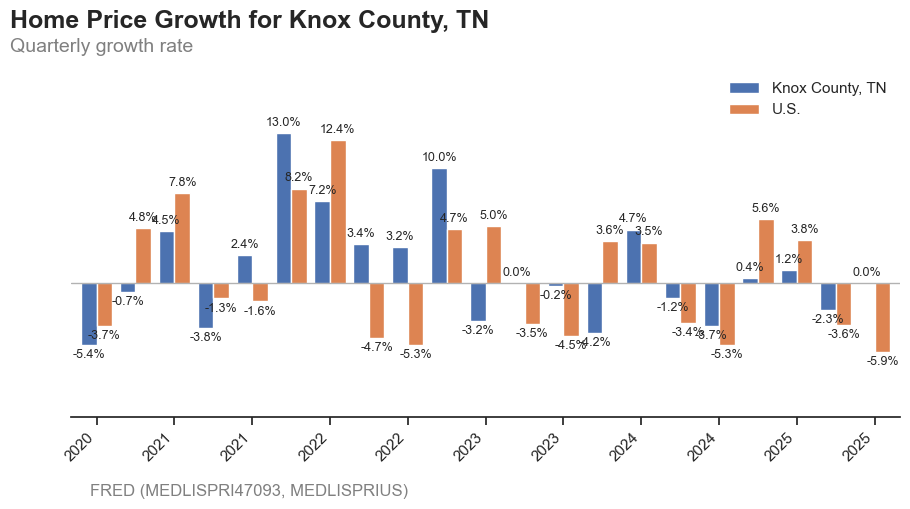

In [73]:
# Median List Price Plot

med_price_us = pd.read_csv(
    "data/cleaned/MEDLISPRIUS.csv", index_col="Date"
)  # , parse_dates=["Date"])
med_price_knox = pd.read_csv(
    "data/cleaned/MEDLISPRI47093.csv", index_col="Date"
)  # , parse_dates=["Date"]

med_price = med_price_us.join(med_price_knox)
med_price = med_price.loc[:, ["MEDLISPRIUS", "MEDLISPRI47093"]]
wide = med_price


wide.index = pd.to_datetime(wide.index)
long = med_price.melt(ignore_index=False)
long.dropna(inplace=True)

long = long.loc[long.index.month.isin([3, 6, 9, 12])]
# print(long)
long["pct_chg"] = long.groupby("variable")["value"].pct_change()
long.dropna(inplace=True)

wide = long.pivot_table(index=long.index, columns="variable", values="pct_chg")
# wide.index = pd.to_datetime(wide.index)
wide = wide.loc["2020-12-31":, :]
wide.dropna(inplace=True)

bar_plots.plot_bars(
    df=wide,
    y=["MEDLISPRI47093", "MEDLISPRIUS"],
    footnote="FRED (MEDLISPRI47093, MEDLISPRIUS)",
    title="Home Price Growth for Knox County, TN",
    subtitle="Quarterly growth rate",
    date_format="%Y",
    hide_yaxis=True,
    bar_width=0.8,
    legend_labels=["Knox County, TN", "U.S."],
    file_name="median_price",
    show=True,
)


# med_price.rename(
#     columns={"MEDLISPRI47093": "Knox County, TN", "MEDLISPRIUS": "U.S."}, inplace=True
# )
# last_index_month = med_price.dropna().index.max().month


# df_trans_ind = df_trans_ind.loc[
#     df_trans_ind.index.month.isin([3, 6, 9, 12])
# ]

# df_trans_ind = df_trans_ind.loc[df_trans_ind.index.month.isin(month_mask), :]

# long = med_price.melt(ignore_index=False)

# # period_chg = 1
# # long["pct_chg"] = long.groupby("variable")["value"].pct_change(
# #     periods=period_chg, fill_method=None
# # )

# long["Rebased Index"] = long.groupby("variable")["value"].transform(
#     lambda x: x / x.iloc[0] * 100
# )


# bar_plots.plot_bars(
#     df=wide,
#     y_col="Rebased Index",
#     title=f"{LOOKBACK_YEARS}-Year Home Price Relative Growth (Knox County vs. U.S.)",
#     subtitle=f"Original prices rebased to 100 at {first_index.strftime('%b %d, %Y')}",
#     xlabel=None,
#     ylabel="Index (Base = 100)",
#     xdate_format="%b %Y",
#     footnote="Source: FRED (MEDLISPRI47093, MEDLISPRIUS)",
#     file_name="median-price-rebased",
#     show=True,
# )

A look at the cumulative growth can be more informative. A median list price index for both Knox County and the U.S. was computed and the relative growth in home listing prices can be seen in the chart below. Knox County and overall U.S.home prices tend to follow similar paths over time. However, over Q4 2025 Knox County home price growth began to outpace U.S. average growth. Consequently, the affordability of Knox County homes has fallen relatively over the fourth quarter of 2025 and the beginning of 2026. This my prove to be a short-term move that will again reverse.


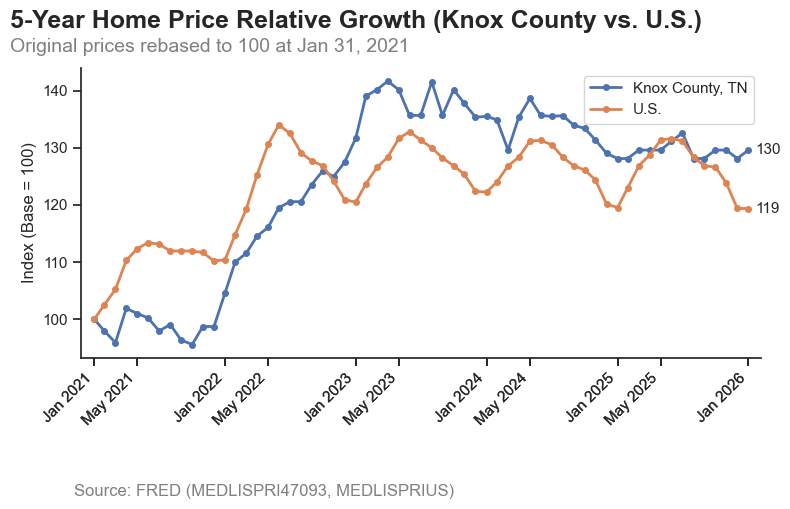

In [74]:
med_price_us = pd.read_csv(
    "data/cleaned/MEDLISPRIUS.csv", index_col="Date"
)  # , parse_dates=["Date"])
med_price_knox = pd.read_csv(
    "data/cleaned/MEDLISPRI47093.csv", index_col="Date"
)  # , parse_dates=["Date"]

med_price = med_price_us.join(med_price_knox)
med_price = med_price.loc[:, ["MEDLISPRIUS", "MEDLISPRI47093"]]
wide = med_price
wide.index = pd.to_datetime(wide.index)
# long = med_price.melt(ignore_index=False)
# long.dropna(inplace=True)

# long["pct_chg"] = long.groupby("variable")["value"].pct_change()
# long.dropna(inplace=True)
# wide = long.pivot_table(index=long.index, columns="variable", values="pct_chg")
# wide.index = pd.to_datetime(wide.index)
# wide.dropna(inplace=True)

# bar_plots.plot_bars(
#     df=wide,
#     y=["MEDLISPRI47093", "MEDLISPRIUS"],
#     footnote="FRED (MEDLISPRI47093, MEDLISPRIUS)",
#     title="Home Price Growth for Knox County, TN",
#     subtitle="YoY growth rate",
#     date_format="%Y",
#     hide_yaxis=True,
#     bar_width=0.8,
#     legend_labels=["Knox County, TN", "U.S."],
#     file_name="median_price",
#     show=True,
# )


LOOKBACK_YEARS = 5
# print(wide)
last_index_date = wide.dropna().index.max()
first_index_date = last_index_date - pd.DateOffset(years=LOOKBACK_YEARS)
med_price = wide.loc[first_index_date:, ["MEDLISPRI47093", "MEDLISPRIUS"]]

med_price.rename(
    columns={"MEDLISPRI47093": "Knox County, TN", "MEDLISPRIUS": "U.S."}, inplace=True
)
last_index_month = med_price.dropna().index.max().month
# # .asfreq("QE")

# # df_trans_ind = df_trans_ind.loc[
# #     df_trans_ind.index.month.isin([3, 6, 9, 12])
# # ]

# # df_trans_ind = df_trans_ind.loc[df_trans_ind.index.month.isin(month_mask), :]

long = med_price.melt(ignore_index=False)
# # period_chg = 1
# # long["pct_chg"] = long.groupby("variable")["value"].pct_change(
# #     periods=period_chg, fill_method=None
# # )

long["Rebased Index"] = long.groupby("variable")["value"].transform(
    lambda x: x / x.iloc[0] * 100
)

long.dropna(inplace=True)

# long["variable"] = long["variable"].replace(
#     {
#         "knox_county_trans_ind": "Knox County Home Price Index",
#         "us_trans_ind": "US Home Price Index",
#     }
# )
# wide = long.pivot_table(index=long.index, columns="variable", values="pct_chg")

first_index = long.index[0]

line_plots.plot_line(
    df=long,
    y_col="Rebased Index",
    title=f"{LOOKBACK_YEARS}-Year Home Price Relative Growth (Knox County vs. U.S.)",
    subtitle=f"Original prices rebased to 100 at {first_index.strftime('%b %d, %Y')}",
    xlabel=None,
    ylabel="Index (Base = 100)",
    xdate_format="%b %Y",
    footnote="Source: FRED (MEDLISPRI47093, MEDLISPRIUS)",
    file_name="median-price-rebased",
    show=True,
)

The Knoxville Metropolitan area experienced significant home price growth over the 5-year period ending September 30, 2025. Home price growth consistently outpaced U.S. average growth over the period as seen in the 5-Year Home Price Growth chart below.


In [ ]:
# from IPython.display import Image, display

# display(Image(filename="plots/housing-price-index-rebased.png"))

# <img src="plots/housing-price-index-rebased.png?v=3" />

In [ ]:
from IPython.display import HTML, display

html = """

<div class="panel-container">
  <div class="panel">
    <div class="panel-title">
      Income required for a home loan downpayment<sup>5</sup>
    </div>
    <div class="panel-date">(2025)</div>
    <div class="panel-group-container">
      <div class="panel-group">
        <div class="panel-subtitle panel-group-subtitle">Knoxville, TN</div>
        <div class="panel-value panel-group-value">$85,892</div>
        <div>(+0.8% Y/Y)</div>
      </div>
    </div>
  </div>
  <div class="panel">
    <div class="panel-title">Monthly cost of homeownership<sup>5</sup></div>
    <div class="panel-date">(2025)</div>
    <div class="panel-group-container">
      <div class="panel-group">
        <div class="panel-subtitle panel-group-subtitle">Knoxville, TN</div>
        <div class="panel-value panel-group-value">$2,581</div>
        <div>(+0.8% Y/Y)</div>
      </div>
    </div>
  </div>
</div>
"""

display(HTML(html))

The homeowner income required for a downpayment on a home loan rose significantly in 2022 and 2023, but flattened and even began to trend downward in Q4 2025. The recent trend is higher home prices with slightly higher monthly payments for new home owners. Income requirements for new home loans remained unchanged over the year.

## Summary

Overall, the recent trend in Knoxville includes growth in total employment and a lower unemployment rate. Hourly wages in Knoxville remained below the national average along with annual cost of living. Moreover, growth in discretionary spending in Tennessee. This imbalance suggests tighter household budgets for Knoxville residents. At the same time, there is evidence that wage growth in Tennessee and surrounding regions is outpacing national average wage growth, indicating improving income dynamics despite current constraints. Rising employment and relative incomes serve as a tailwind for housing demand.


## Footnotes

<sup>2</sup> Knoxville, TN, Area Economic Summary (https://www.bls.gov/regions/southeast/summary/blssummary_knoxville.pdf). Total employment refers to total nonfarm employment.

<sup>3</sup> Median annual income (https://www.justice.gov/ust/eo/bapcpa/20240401/bci_data/median_income_table.htm)

<sup>4</sup>

<sup>5</sup> Zillow housing data (https://www.zillow.com/research/data/?msockid=1e635bc70b80661b06994d010a196723). Monthly cost of homeownership includes the mortgage payment, homeowner's insurance, property taxes and maintenance costs. Income required for a home loan downpayment is the average homeowner income required for downpayment on a home loan


In [ ]:
# # Multiple Regression

# # Correlation Matrix
# import seaborn as sns
# import matplotlib.pyplot as plt

# # Assuming 'housing_df' is the DataFrame containing the data
# # Plotting the correlation matrix
# print(df.head())
# plt.figure(figsize=(10, 8))
# sns.heatmap(df.corr(), annot=True, cmap='coolwarm')
# plt.title('Correlation Matrix')
# plt.show()

In [ ]:
# plot_data = df.loc["2020":, ["knox_pop", "us_pop"]].copy()


# fig, ax = plt.subplots(figsize=(8, 4))

# # Colors for positive/negative
# colors = ["skyblue" if v >= 0 else "pink" for v in pct_chg]

# # Convert dates to string labels
# labels = pct_chg.index.strftime("%Y-%m-%d")

# # Use positions instead of datetime index
# positions = range(len(pct_chg))

# # Single bar plot
# ax.bar(
#     positions,
#     pct_chg,
#     width=0.8,
#     color=colors,
#     edgecolor="gray",
#     alpha=0.6,
#     linewidth=1.5,
# )

# # set tick labels to full date strings
# ax.set_xticks(positions)
# ax.set_xticklabels(labels, rotation=0, ha="center")

# # Remove y-axis ticks/labels
# ax.set_ylabel("")
# ax.tick_params(axis="y", which="both", left=False, labelleft=False)

# ax.set_title(
#     "Knoxville Population Growth (YoY)",
#     fontsize=18,
#     fontweight="bold",
#     loc="left",
#     pad=14,
# )
# ax.set_xlabel("")

# # Remove spines
# ax.spines["top"].set_visible(False)
# ax.spines["right"].set_visible(False)
# ax.spines["left"].set_visible(False)

# # Annotate each bar using positions
# for x, y in zip(positions, pct_chg):
#     ax.annotate(
#         f"{y:.1%}",
#         xy=(x, y),
#         xytext=(0, 5),
#         textcoords="offset points",
#         ha="center",
#         fontsize=12,
#     )

# plt.show()

In [ ]:
# import pandas as pd

# # Create a copy of the raw data
# df = raw.copy()

# # Reformat column names
# df.columns = [c.replace(".", "_") for c in df.columns]
# df.rename(
#     columns={"DT": "Date", "variable": "Variable", "value": "Value"}, inplace=True
# )

In [ ]:
# Convert date column to datetime
# df["Date"] = pd.to_datetime(df["Date"], format="%Y%m%d")
# df["Date"] = df["Date"].dt.date

In [ ]:
# # Drop unnecessary columns
# df.drop("column0", axis=1, inplace=True)

# # Does every Geography_Name have exactly one CBSA_Code and vice versa?
# if (df.groupby("Geography_Name")["CBSA_Code"].nunique() == 1).all() and (
#     df.groupby("CBSA_Code")["Geography_Name"].nunique() == 1
# ).all():
#     print(
#         "True. Every Geography_Name has exactly one CBSA_Code and vice versa so there is a 1-to-1 relationship between the variables and it's safe to drop the CBSA_Code column."
#     )
#     # Drop the CBSA_Code column
#     df.drop("CBSA_Code", axis=1, inplace=True)
# else:
#     print("False. There is not a 1-to-1 mapping between Geography_Name and CBSA_Code.")

In [ ]:
# Find missing values
# df.isna().sum()

In [ ]:
# cremi = df[df["Variable"] == "CREMI"].copy()
# cremi.drop("Variable", axis=1, inplace=True)
# cremi.rename(columns={"Value": "CREMI"}, inplace=True)

In [ ]:
# Show unique asset types
# print(cremi["Asset_Type"].value_counts().map("{:,}".format))

In [ ]:
# Show unique geographic regions
# print(f"{len(cremi["Geography_Name"].unique())} unique regions")

In [ ]:
# cremi["Start_Date"] = cremi.groupby(["Geography_Name", "Asset_Type"])["Date"].transform(
#     "min"
# )
# cremi["End_Date"] = cremi.groupby(["Geography_Name", "Asset_Type"])["Date"].transform(
#     "max"
# )

# cremi[
#     ["Geography_Name", "Asset_Type", "Start_Date", "End_Date"]
# ].drop_duplicates().reset_index(drop=True)

In [ ]:
# import pandas as pd
# from datetime import date
# import seaborn as sns
# import matplotlib.pyplot as plt
# from matplotlib.patches import Rectangle


# mf = (
#     cremi[cremi["Asset_Type"] == "Multifamily"].copy().drop("Asset_Type", axis=1)
# )  # Extract the State
# mf["State"] = mf["Geography_Name"].str.split(" - ").str[1]
# mf["State"].nunique()
# by_state = mf.groupby(["State", "Date"]).agg({"CREMI": "mean"}).reset_index()

# by_state["CREMI_MA(1Y)"] = (
#     by_state.groupby("State")["CREMI"]
#     .rolling(window=4, min_periods=4)
#     .mean()
#     .reset_index(level=0, drop=True)
# )

# # Get values for most recent date
# # by_state = by_state.sort_values('Date').groupby('State').tail(4)
# by_state = by_state[by_state["Date"] >= date(2024, 9, 30)]


# # Step 1: Flag positive momentum
# by_state["+ Momentum"] = (by_state["CREMI"] > by_state["CREMI_MA(1Y)"]) & (
#     by_state["CREMI"] > 0
# )

# # Step 2: Keep only rows with positive momentum
# positive = by_state[by_state["+ Momentum"]].copy()

# # Only keep top 5 states per date (or filter as needed)
# # top5 = (
# #     positive.groupby('Date')
# #     .apply(lambda x: x.nlargest(5, 'CREMI'))  # x still contains 'Date', 'CREMI', etc.
# #     .reset_index(drop=True)
# # )

# positive["Rank"] = positive.groupby("Date")["CREMI"].rank(
#     method="first", ascending=False
# )
# top5 = positive[positive["Rank"] <= 5].copy()


# # Plot using seaborn
# import matplotlib.pyplot as plt
# import numpy as np

# import matplotlib.pyplot as plt
# import numpy as np

# # Unique states and assign colors
# states = top5["State"].unique()
# cmap = plt.get_cmap("tab10")
# colors = [cmap(i) for i in range(cmap.N)]  # cmap.N = 10
# state_to_color = {state: colors[i % len(colors)] for i, state in enumerate(states)}

# # Unique dates
# dates = sorted(top5["Date"].unique())

# # Bar width
# width = 0.15
# fig, ax = plt.subplots(figsize=(12, 6))

# # Plot bars
# for i, d in enumerate(dates):
#     date_data = top5[top5["Date"] == d].sort_values("CREMI")  # Sort ascending

#     n = len(date_data)
#     x = i + np.arange(n) * width  # positions for bars in this group
#     for j, row in enumerate(date_data.itertuples()):
#         ax.bar(x[j], row.CREMI, width=width, color=state_to_color[row.State])
#         ax.text(
#             x[j],
#             row.CREMI + 0.01,
#             f"{row.CREMI:.2f}",
#             ha="center",
#             va="bottom",
#             fontsize=9,
#         )

# # X-ticks in the center of each group
# group_centers = [
#     i + (len(top5[top5["Date"] == d]) - 1) * width / 2 for i, d in enumerate(dates)
# ]
# # Add value label above the bar

# ax.set_xticks(group_centers)
# ax.set_xticklabels(dates, rotation=45)
# ax.set_ylabel("CREMI")
# ax.set_title("Top CREMI States by Date (+ Momentum)")

# # Create legend with correct colors
# handles = [Rectangle((0, 0), 1, 1, color=state_to_color[state]) for state in states]
# ax.legend(handles, states, title="State", loc="upper left", ncol=len(states))

# plt.tight_layout()
# plt.show()


# # # Step 3: Rank states by CREMI for each date (highest CREMI = rank 1)
# # positive['Rank'] = positive.groupby('Date')['CREMI'].rank(method='first', ascending=False)

# # # Step 4: Keep top 5 states per date
# # top5 = positive[positive['Rank'] <= 5]

# # print(top5.sort_values(["Date"]))
# # # Step 5: Pivot so each state is a column
# # pivoted = top5.pivot(index='Date', columns='State', values='CREMI')


# # subset = by_state[
# #     (by_state['Date'] > date(2024, 1, 1)) &
# #     (by_state['State'].isin(['AZ', 'CA', 'TN']))
# # ]

# # # print(subset.columns.tolist())

In [ ]:
# out = con.execute(
#     """
#     SELECT Geography_Name, Asset_Type, Date, Value
#     FROM df
#     WHERE Asset_Type = 'Multifamily'
#     """
# ).fetchdf()
# print(out)